# Sparse Logistic Regression

This tutorial demonstrates modeling and running inference on a sparse logistic regression model in Bean Machine. This tutorial showcases the inference techniques in Bean Machine, and applies the model to a public dataset to evaluate performance. It also introduces the `@bm.functional` decorator, which can be used to deterministically transform random variables which can be convenient for post-processing.

## Problem

Logistic regression is a commonly used statistical method that allows us to predict a binary output from a set of independent variables. The sparse logistic regression is a type of logistic regression model which embeds feature selection in classification by adding overall and per-dimension scale factors. It is very applicable when dealing with high-dimensional data, such as classifying credit scores.

Sparse logistic regression is a hierarchical model with a sparse prior. We will use a [horseshoe prior](http://proceedings.mlr.press/v5/carvalho09a/carvalho09a.pdf) which induces sparsity using a combination of a global shrinkage scale factor that pushes the posterior mass of most model parameters to zero and a local scale that allows some of them to escape shrinkage.

## Prerequisites

Please import the following code packages for the rest of the code in the tutorial to work.

In [ ]:
import sys
if 'google.colab' in sys.modules and 'beanmachine' not in sys.modules:
    !pip install beanmachine  # For running on Google  Colab

In [1]:
import io
import logging
import math
import os
import warnings
import zlib

import arviz as az
import beanmachine.ppl as bm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection
import torch
import torch.distributions as dist
from torch import tensor

plt.rc('axes', xmargin=0, ymargin=0)
plt.rc('figure', figsize=[8, 6])
plt.rc('font', size=14)
plt.rc('hist', bins=30)
plt.rc('lines', linewidth=2.5)

np.set_printoptions(precision=3)
pd.set_option('precision', 3)

logging.getLogger("beanmachine").setLevel(50)
bm.seed(17);

smoke_test = ('SANDCASTLE_NEXUS' in os.environ or 'CI' in os.environ)

## Model

We have the following definitions.

  * $N$: Size of the dataset.
  * $D$: Number of features of the dataset.
  * $\tau$: Global shrinkage of the model (input from the user).
  * $\beta_d$: Coefficient corresponding to dimension $d \in D$.
  * $\lambda_d$: Local shrinkage for the coefficient corresponding to dimension $d \in D$.

The model is defined mathematically as follows:

  * $\lambda_d \stackrel{iid}{\sim} \text{HalfCauchy}(0, 1)$
  * $\beta_d \stackrel{iid}{\sim} \mathcal{N}(0, \tau \lambda)$
  * $y_n \stackrel{iid}{\sim} \text{Bernoulli}(\sigma({X}^\textsf{T}\beta))$

A few notes:

  * $\sigma(s) = \frac{1}{1 + e^{ -s } }$ is the logistic function. Its purpose is to translate an unconstrained score $s \in (-\infty, \infty)$ predicted by the model into a probability $\sigma(s) \in (0, 1)$.
  * $\tau$ can be an input from the user which depends on the expected number of non-zeros coefficients in the model. Alternatively, we can have a full Bayesian treatment of $\tau$ as suggested in ["Sparsity information and regularization in the horseshoe and other shrinkage priors"](https://arxiv.org/pdf/1707.01694.pdf). For simplicity, this is simply a constant in this tutorial but this can be replaced with a HalfNormal prior with the same scale as $\tau$. This parameter is responsible for global shrinkage, whereas $\lambda_d$ tends to shrink the influence of $\beta_d$ but since the Cauchy distribution has fat tails, it can also help coefficients escape shrinkage. 


We can implement this model in Bean Machine by defining random variable objects with the `@bm.random_variable` decorator. These functions behave differently than ordinary Python functions.

<div style="background: #daeaf3; border-left: 3px solid #2980b9; display: block; margin: 16px 0; padding: 12px;">
  Semantics for <code>@bm.random_variable</code> functions:
  <ul>
    <li>They must return PyTorch <code>Distribution</code> objects.
    <li>Though they return distributions, callees actually receive <i>samples</i> from the distribution. The machinery for obtaining samples from distributions is handled internally by Bean Machine.
    <li>Inference runs the model through many iterations. During a particular inference iteration, a distinct random variable will correspond to exactly one sampled value: <b>calls to the same random variable function with the same arguments will receive the same sampled value within one inference iteration</b>. This makes it easy for multiple components of your model to refer to the same logical random variable.
    <li>Consequently, to define distinct random variables that correspond to different sampled values during a particular inference iteration, an effective practice is to add a dummy "indexing" parameter to the function. Distinct random variables can be referred to with different values for this index.
    <li>Please see the documentation for more information about this decorator.
  </ul>
</div>

To implement sparse logistic regression model in Bean Machine, we provide `@bm.random_variable` definitions for $\lambda$, $\beta$, and $y$. The value of $\tau$ is estimated from the number of expected non-zero coefficients and is an input from the user.

This is all you have to do to define the model. However, we'll also make use of the `@bm.functional` decorator to make it very easy to store the predictions (rather than the binary outcome, we'll store the probability score of being labeled 1) on the test data and for computing the log likelihood. This decorator has the same semantics as `@bm.random_variable`, except that it does not return a distribution. Instead, it returns a deterministically-computed function from other random variables. It can be used to conveniently compute values that would typically be computed in a post-processing pass. Here, we use it to compute the log probability of test data, using inferences made on training data.

In [2]:
class SparseLogisticRegression(object):
    
    def __init__(self, X_train, X_test, Y_test, nonzero_frac=0.3):
        super().__init__()
        self.X_train = X_train
        self.X_test = X_test
        self.Y_test = Y_test
        # See: https://arxiv.org/pdf/1707.01694.pdf
        self.tau = 2 * nonzero_frac / ((1 - nonzero_frac) * math.sqrt(self.X_train.shape[1]))
        
    @bm.random_variable
    def lambda_(self):
        return dist.HalfCauchy(1.).expand([self.X_train.shape[1], 1])

    @bm.random_variable
    def eps(self):
        return dist.Normal(0, 1).expand([self.X_train.shape[1], 1])

    @bm.random_variable
    def y(self):
        return dist.Bernoulli(
            logits=self.X_train @ self.beta()
        )
    
    @bm.functional
    def beta(self):
        return self.tau * self.lambda_() * self.eps()

    @bm.functional
    def log_prob_test(self):
        return dist.Bernoulli(
            logits=self.X_test @ self.beta()
        ).log_prob(self.Y_test).sum()
    
    @bm.functional
    def y_probs(self):
        return torch.sigmoid(self.X_test @ self.beta())
    
    def __repr__(self):
        return f"SparseLogisticRegression with {self.X_train.shape[1]} covariates"

## Data

With the model defined, we need to collect some observed data in order to learn about values of interest in our model. For this tutorial, we'll use 1,000 five-dimensional datapoints where the response only depends on the first two, so that we can visualize what's going on.

We will generate a dataset where items have true label 0 and true label 1. For demonstrative purposes, we will use a synthetically generated dataset of observed values. In practice, you would gather real data and classify results by-hand, for example using human labelers.

In [3]:
X = dist.Normal(0, 5).expand([1000, 5]).sample()

tau0 = 2 * 0.3 / (0.7 * math.sqrt(1000))
lambda0 = torch.tensor([-70, 40, 0, 0, 0]).unsqueeze(-1)
true_beta = tau0 * lambda0

Y = dist.Bernoulli(logits=X @ true_beta).sample()

In [4]:
tau0, true_beta

(0.02710523708715754,
 tensor([[-1.8974],
         [ 1.0842],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]]))

Let's take a moment to visualize our dataset.

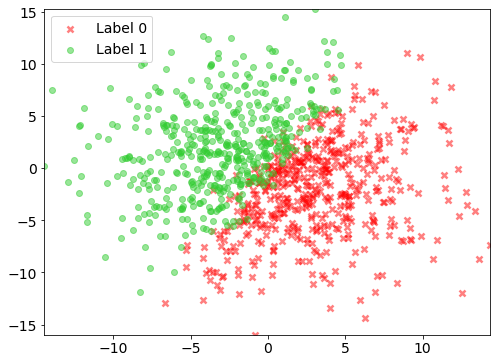

In [5]:
X_ = X[:, :2]  # Only the first 2 dims determine the outcome
plt.scatter(
    X_[Y[:, 0] == 0, 0],
    X_[Y[:, 0] == 0, 1],
    label="Label 0",
    color="red",
    marker="x",
    alpha=0.5,
)
plt.scatter(
    X_[Y[:, 0] == 1, 0],
    X_[Y[:, 0] == 1, 1],
    label="Label 1",
    color="limegreen",
    marker="o",
    alpha=0.5,
)
plt.legend();

Now, we will split the dataset into a training set and a test set.

In [6]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y)

Now that we've got our data defined, we can instantiate an instance of the model.

In [7]:
model = SparseLogisticRegression(X_train, X_test, Y_test)

Our inference algorithms expect observations in the form of a dictionary. This dictionary should consist of `@bm.random_variable` invocations as keys, and tensor data as values. In order to bind this data, first we'll instantiate the model.

In [8]:
observations = { model.y(): Y_train }

## Inference

Inference is the process of combining _model_ with _data_ to obtain _insights_, in the form of probability distributions over values of interest. Bean Machine offers a powerful and general inference framework to enable fitting arbitrary models to data.

Since this model is comprised entirely of differentiable random variables, we'll make use of the No U-Turn Sampler (NUTS) (Hoffman & Gelman, 2011). 

Running inference consists of a few arguments:

| Name | Usage
| --- | ---
| `queries` | A list of `@bm.random_variable` targets to fit posterior distributions for.
| `observations` | The `Dict` of observations we built up, above.
| `num_samples` | Number of samples to build up distributions for the values listed in `queries`.
| `num_chains` | Number of separate inference runs to use. Multiple chains can verify inference ran correctly.

Let's run inference:

In [9]:
num_samples = 5 if smoke_test else 1000

In [10]:
samples = bm.GlobalNoUTurnSampler().infer(
    queries=[
        model.lambda_(),
        model.beta(),
        model.log_prob_test(),
        model.y_probs(),
    ],
    observations=observations,
    num_adaptive_samples=num_samples//2,
    num_samples=num_samples,
    num_chains=2,
)

Samples collected:   0%|          | 0/1500 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/1500 [00:00<?, ?it/s]

## Analysis

`samples` now contains our inference results.

First, we'll just print previews of the results. This should give a sense of how to work with the `samples` object, and also an idea of the shapes of the inferred values.

In [11]:
lambda_marginal = samples[ model.lambda_() ].flatten(start_dim=0, end_dim=1).detach()
beta_marginal = samples[ model.beta() ].flatten(start_dim=0, end_dim=1).detach()
log_prob_test_results = samples[ model.log_prob_test() ][0].detach()

print(
    f"lambda_marginal:\n{lambda_marginal}\n\n"
    f"beta_marginal:\n{beta_marginal}\n\n"
    f"log_prob_test_results:\n{log_prob_test_results[:20]}"
)

lambda_marginal:
tensor([[[2.8394],
         [4.5057],
         [0.0509],
         [0.1757],
         [0.1981]],

        [[3.8439],
         [4.0732],
         [0.2876],
         [0.3533],
         [0.0926]],

        [[4.9957],
         [4.7306],
         [1.0813],
         [0.5233],
         [0.0411]],

        ...,

        [[3.8136],
         [4.5104],
         [3.0584],
         [0.4713],
         [1.3888]],

        [[3.9713],
         [4.8995],
         [0.2248],
         [0.2639],
         [0.2774]],

        [[4.5894],
         [2.3223],
         [0.1375],
         [0.1926],
         [0.3212]]])

beta_marginal:
tensor([[[-1.6201],
         [ 1.0129],
         [ 0.0138],
         [ 0.0399],
         [-0.0248]],

        [[-1.9610],
         [ 1.2007],
         [ 0.0216],
         [ 0.0499],
         [-0.0097]],

        [[-1.9224],
         [ 1.1987],
         [ 0.0511],
         [-0.0088],
         [-0.0143]],

        ...,

        [[-1.8225],
         [ 1.1098],
         [ 

Next, let's visualize the inferred random variables.

In [12]:
def plot_marginal(marginal_samples, variable_name, true_value=None):
    
    marginal_samples = marginal_samples.squeeze()

    if len(marginal_samples.shape) == 1:
        plt.title(f"{variable_name} marginal")
        plt.hist(marginal_samples.numpy(), density=True)
        if true_value:
            plt.axvline(x=true_value, label="True value", color="k")
        plt.axvline(x=marginal_samples.mean(), label="Posterior mean", color="c")
        plt.xlabel(variable_name)
        plt.ylabel("density")
        plt.legend()
    
    elif len(marginal_samples.shape) == 2 and marginal_samples.shape[1] == 2:
        plt.suptitle(f"{variable_name} marginal", fontsize=20)
        
        grid = mpl.gridspec.GridSpec(4, 4)

        plt.subplot(grid[1:, :3])
        plt.hist2d(*marginal_samples.T.tolist(), bins=60, density=True)
        if true_value is not None:
            plt.plot(*true_value.numpy(), "wo", label="True value")
        plt.plot(*marginal_samples.mean(dim=0).numpy(), "ro", label="Posterior marginal mean")
        plt.xlabel(f"{variable_name}[0]")
        plt.ylabel(f"{variable_name}[1]")
        plt.legend()

        plt.subplot(grid[0, :3])
        plt.hist(marginal_samples[:, 0].numpy(), density=True)
        if true_value is not None:
            plt.axvline(true_value[0].numpy(), color="k")
        plt.axvline(marginal_samples[:, 0].mean().numpy(), color="c")
        plt.ylabel("density")
        plt.gca().axes.get_xaxis().set_ticklabels([])
        plt.margins(0)

        plt.subplot(grid[1:, 3])
        plt.hist(marginal_samples[:, 1].numpy(), density=True, orientation="horizontal")
        if true_value is not None:
            plt.axhline(true_value[1].numpy(), color="k")
        plt.axhline(marginal_samples[:, 1].mean().numpy(), color="c")
        plt.xlabel("density")
        plt.gca().axes.get_yaxis().set_ticklabels([])
        plt.margins(0)
        
    else:
        raise Exception(
            f"Excepted: marginal_samples with shape [:] or [:, 2, :].\n"
            f"Received: marginal_samples with shape {marginal_samples.shape}."
        )
        
    plt.show()

Below we plot the joint of the first two components of $\beta$ and $\lambda$ (as a reminder, the remaining components are noise which the outcome variable doesn't depend on).

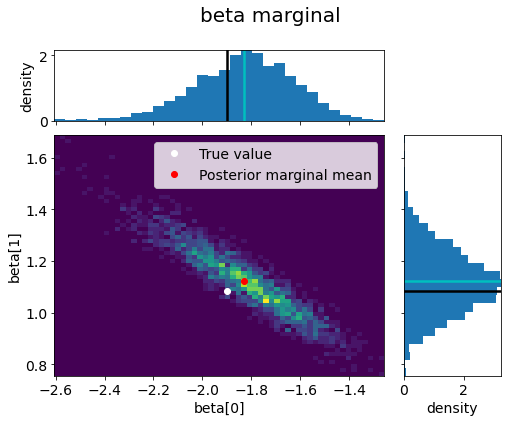

In [13]:
plot_marginal(beta_marginal[:, :2], "beta", true_beta[:2, :])

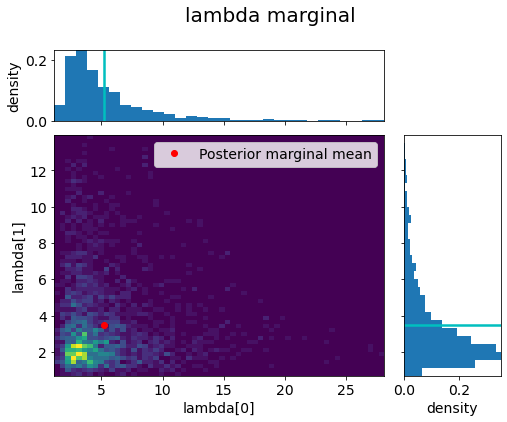

In [14]:
plot_marginal(lambda_marginal[:, :2], "lambda")

The marginals and the joint for $\beta$ and $\lambda$ look reasonable. We note that posterior mean for $\beta$ closely matches the true values used to generate the data. Note that the $\lambda$ values can be fairly large if needed since we place a `HalfCauchy` prior over it. Even in the presence of strong global shrinkage, this lets local parameters take on larger values if needed. 

Now let us look at the histogram for the remaining values of $\beta$, i.e. the coefficients for variables which have no effect on the outcome.

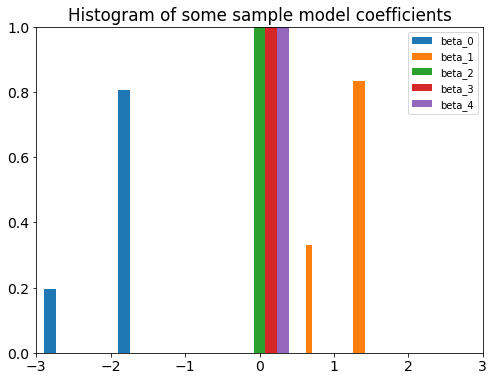

In [15]:
betas = samples[model.beta()].squeeze(-1).reshape(-1, 5)

bins = [-3, -2, -1, -0.5, 0.5, 1, 2, 3]
plt.hist(betas.numpy(), bins=bins, density=True, histtype='bar', label=[f'beta_{i}' for i in range(5)])
plt.legend(prop={'size': 10})
plt.title('Histogram of some sample model coefficients')
plt.xlim(-3, 3);

We note that the majority of the posterior mass on all the variables that the outcome doesn't depend on is centered at 0 and the only non-zero values are the first two variables. This validates how the horseshoe prior helps induce sparsity. 

Lastly, let's plot the first thousand log probabilities on test data that we generated per-iteration during inference. We'll also overlay the log probability that the test datast would score on the ground truth parameters.

In [16]:
def plot_log_prob(log_prob_results, ground_truth_log_prob=None):
    plt.figure(figsize=(20, 6))
    plt.plot(log_prob_results)
    if ground_truth_log_prob:
        plt.axhline(
            ground_truth_log_prob,
            label=f"Using true params = {ground_truth_log_prob :.2f}",
            color="k",
        )
        plt.legend()
    plt.ylabel("Log probability")
    plt.margins(0.02)
    plt.show()

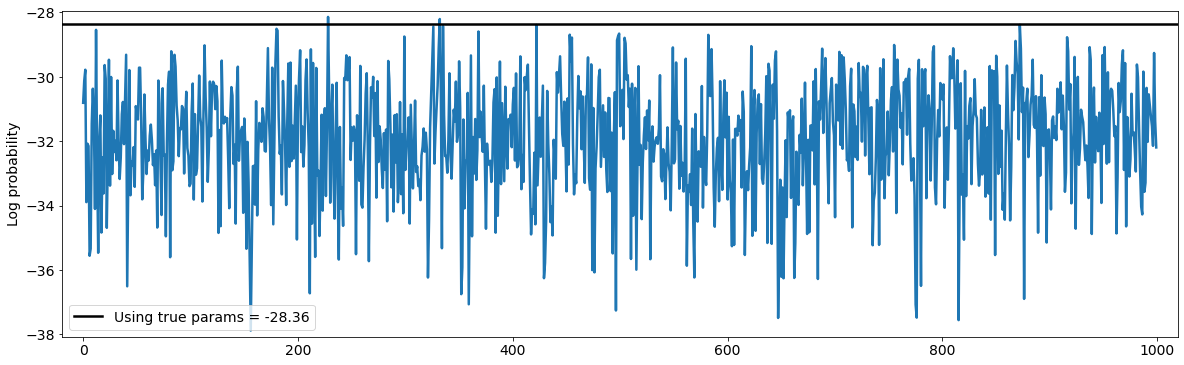

In [17]:
plot_log_prob(
    log_prob_test_results,
    dist.Bernoulli(
        logits=X_test @ true_beta
    ).log_prob(Y_test).sum(),
)

Let us plot the predictions from the model on the test dataset as a sanity check. For simplicity, we will compute the mean of the probability score (computed as `y_probs` in the model) on each test datapoint and assume a label of 0 if the score is less than 0.5 and conversely a label of 1 if the score is above 0.5.

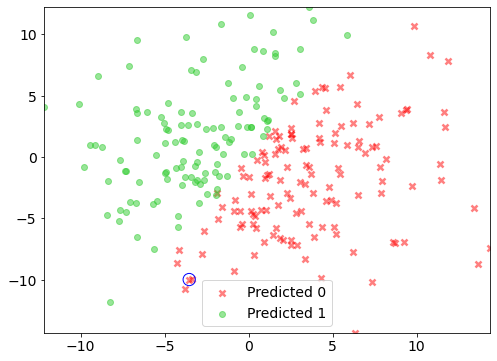

In [18]:
y_probs = samples[model.y_probs()].mean([0, 1])
plt.scatter(
    X_test[y_probs[:, 0] < 0.5, 0],
    X_test[y_probs[:, 0] < 0.5, 1],
    label="Predicted 0",
    color="red",
    marker="x",
    alpha=0.5,
)
plt.scatter(
    X_test[y_probs[:, 0] >= 0.5, 0],
    X_test[y_probs[:, 0] >= 0.5, 1],
    label="Predicted 1",
    color="limegreen",
    marker="o",
    alpha=0.5,
)
plt.scatter(X_test[11, 0], X_test[11, 1], s=150, facecolors='none', edgecolors='b')
plt.legend();

As we can see, the model seems to have recovered the same decision boundary, and MCMC has converged to parameters that correctly predicted the test dataset. This was just a sanity check. Since we have built a probabilistic model, the probability that each datapoint has label 1 is itself a distribution! Let us see this for one of the test datapoints (marked by a blue circle above).

Text(0.5, 1.0, 'Probability of test datapoint 11 having Label 1')

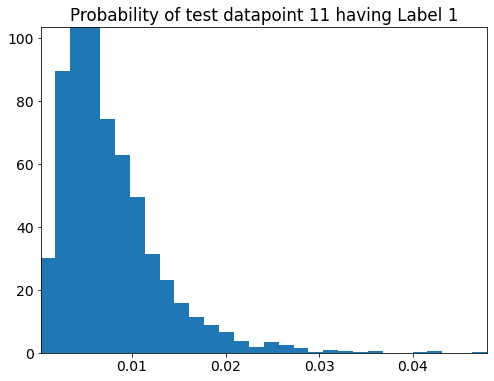

In [19]:
plt.hist(samples[model.y_probs()][..., 11, 0].reshape(-1).numpy(), density=True)
plt.title("Probability of test datapoint 11 having Label 1")

The `MonteCarloSamples` from Bean Machine's inference can be converted to arviz's internal `InferenceData` format so that we can make use of its inference statistics and plotting utilities for diagnostics.

In [20]:
from beanmachine.ppl.inference.monte_carlo_samples import MonteCarloSamples

with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # Arviz seems to throw a spurious Userwarning about num_chains > num_draws
    filtered_samples = {k: v for k, v in samples.items() if k in {model.beta(), model.lambda_()}}
    az_data = MonteCarloSamples(filtered_samples).to_inference_data()
az.summary(az_data, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta(SparseLogisticRegression with 5 covariates,)[0, 0]",-1.829,0.201,-2.217,-1.479,0.005,0.003,1924.440,1227.552,1.000
"beta(SparseLogisticRegression with 5 covariates,)[1, 0]",1.122,0.125,0.904,1.359,0.003,0.002,2020.560,1517.263,1.000
"beta(SparseLogisticRegression with 5 covariates,)[2, 0]",0.019,0.031,-0.041,0.077,0.001,0.001,1255.145,1770.287,1.000
"beta(SparseLogisticRegression with 5 covariates,)[3, 0]",0.035,0.032,-0.018,0.098,0.001,0.001,1026.378,1603.512,1.000
"beta(SparseLogisticRegression with 5 covariates,)[4, 0]",-0.056,0.039,-0.131,0.010,0.001,0.001,1215.867,1086.903,1.000
"lambda_(SparseLogisticRegression with 5 covariates,)[0, 0]",5.192,3.347,1.411,11.310,0.167,0.118,444.694,623.956,1.000
"lambda_(SparseLogisticRegression with 5 covariates,)[1, 0]",3.485,2.395,0.727,8.597,0.104,0.076,589.498,611.459,1.006
"lambda_(SparseLogisticRegression with 5 covariates,)[2, 0]",0.510,0.875,0.000,1.583,0.033,0.023,463.199,599.318,1.003
"lambda_(SparseLogisticRegression with 5 covariates,)[3, 0]",0.568,0.803,0.001,1.794,0.029,0.021,481.450,507.749,1.002
"lambda_(SparseLogisticRegression with 5 covariates,)[4, 0]",0.618,0.751,0.004,1.743,0.026,0.018,496.752,652.592,1.007


The summary above includes useful statisics about each marginal distribution.

The summary output also shows two diagnostic statistics: [$\hat{R}$](https://projecteuclid.org/euclid.ss/1177011136) (`r_hat`) and [$N_\text{eff}$](https://www.mcmchandbook.net/HandbookChapter1.pdf) (effective sample size, `n_eff`).

  * $\hat{R} \in [1, \infty)$ summarizes how effective inference was at converging on the correct posterior distribution for a particular random variable. It uses information from all chains run in order to assess whether inference had a good understanding of the distribution or not. Values very close to zero indicate that all chains discovered similar distributions for a particular random variable. We do not recommend using inference results where $\hat{R} > 1.1$, as inference may not have converged. In that case, you may want to run inference for more samples.
  * $N_\text{eff} \in [1, \texttt{num}\_\texttt{samples}]$ summarizes how independent posterior samples are from one another. Although inference was run for `num_samples` iterations, it's possible that those samples were very similar to each other (due to the way inference is implemented), and may not each be representative of the full posterior space. Larger numbers are better here, and if your particular use case calls for a certain number of samples to be considered, you should ensure that $N_\text{eff}$ is at least that large.
  
In this case, $\hat{R}$ seems to have generally acceptable values. It is on the high end for $\lambda$, which is in-line with teh spread of the marginals that we saw previously. $N_\text{eff}$ is on the lower end, so it may be desirable to run inference for longer.

For comparison, let's check out the model's performance using a couple of different inference methods.

## Single-site Metropolis-Hastings

Let's retry this problem, using ancestral Metropolis-Hastings as the inference algorithm to compare performance.

Ancestral Metropolis-Hastings is a simple inference algorithm, which proposes child random variables conditional on values for the parent random variables. The most ancestral random variables are simply sampled from the prior distribution.

In [21]:
samples_mh = bm.SingleSiteAncestralMetropolisHastings().infer(
    queries=[
        model.lambda_(),
        model.beta(),
        model.log_prob_test(),
    ],
    observations=observations,
    num_samples=2*num_samples,
    num_chains=2,
)


Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

In [22]:
lambda_marginal = samples_mh[ model.lambda_() ].flatten(start_dim=0, end_dim=1).detach()
beta_marginal = samples_mh[ model.beta() ].flatten(start_dim=0, end_dim=1).detach()
log_prob_test_results = samples_mh[ model.log_prob_test() ].flatten(start_dim=0, end_dim=1).detach()

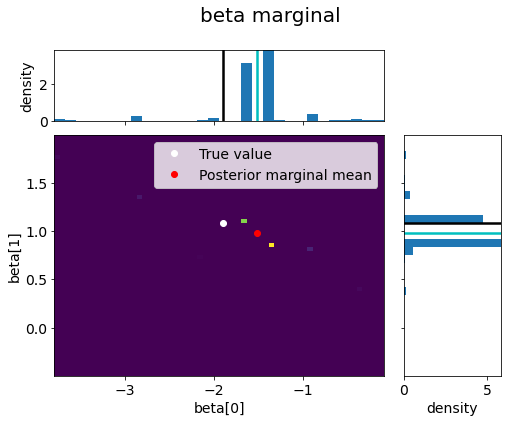

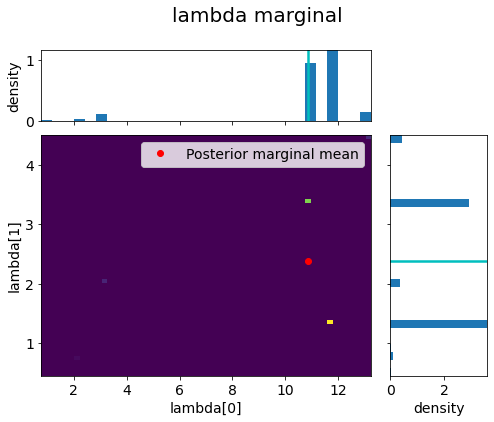

In [23]:
plot_marginal(beta_marginal[:, :2], "beta", true_beta[:2, :])
plot_marginal(lambda_marginal[:, :2], "lambda")

From all of the above plots, we see that ancestral Metropolis-Hastings does a significantly worse job at recovering the true parameters! Not only do regions of uncertainty tend to _exclude_ the true values, the samples that are actually drawn are very sparse. This means that the algorithm is achieving a very poor representation of the posterior surface.

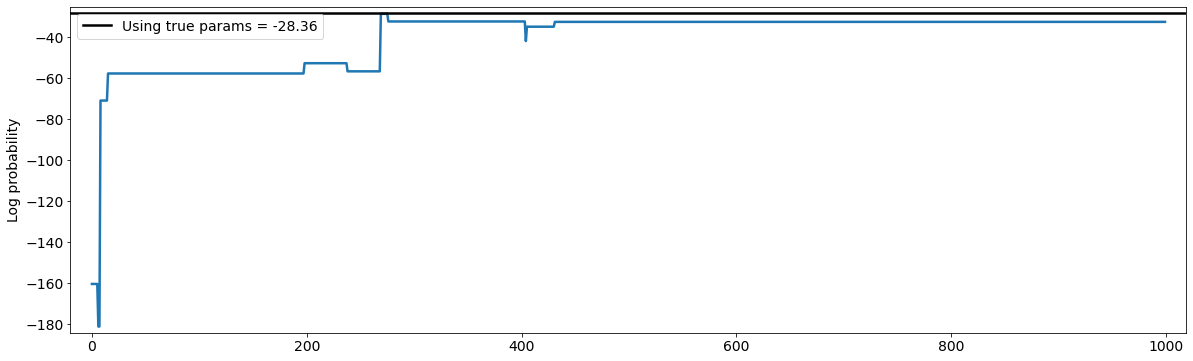

In [24]:
plot_log_prob(
    log_prob_test_results[:1000],
    dist.Bernoulli(
        logits=X_test @ true_beta
    ).log_prob(Y_test).sum()
)

Surprisingly, the algorithm does eventually discover -- and settle in on -- parameters that seem to descirbe the test data well.

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # Arviz seems to throw a spurious Userwarning about num_chains > num_draws
    display(az.summary(samples_mh.to_inference_data(), round_to=3))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"log_prob_test(SparseLogisticRegression with 5 covariates,)",-34.747,13.590,-57.872,-31.230,2.642,1.889,2.994,15.256,1.787
"beta(SparseLogisticRegression with 5 covariates,)[0, 0]",-1.514,0.423,-2.127,-0.906,0.094,0.067,5.510,22.985,2.094
"beta(SparseLogisticRegression with 5 covariates,)[1, 0]",0.979,0.195,0.795,1.347,0.093,0.071,4.935,17.376,2.054
"beta(SparseLogisticRegression with 5 covariates,)[2, 0]",0.023,0.025,-0.038,0.041,0.013,0.010,3.026,7.657,1.761
"beta(SparseLogisticRegression with 5 covariates,)[3, 0]",0.036,0.056,-0.009,0.080,0.032,0.025,2.527,2.043,2.359
"beta(SparseLogisticRegression with 5 covariates,)[4, 0]",0.020,0.083,-0.188,0.082,0.043,0.034,2.943,8.726,1.849
"lambda_(SparseLogisticRegression with 5 covariates,)[0, 0]",10.861,2.143,3.161,13.240,0.417,0.298,9.639,15.256,2.029
"lambda_(SparseLogisticRegression with 5 covariates,)[1, 0]",2.383,1.092,0.764,3.401,0.711,0.582,2.606,2.017,2.735
"lambda_(SparseLogisticRegression with 5 covariates,)[2, 0]",1.054,0.938,0.113,1.993,0.662,0.560,2.519,18.072,2.463
"lambda_(SparseLogisticRegression with 5 covariates,)[3, 0]",0.624,0.664,0.036,1.399,0.430,0.352,3.802,18.072,4.017


$\hat{R}$ values are extremely far from 1.0. Further, the $N_\text{eff}$ values for our sampled random variables are extremely small. As a result, these inference results would be unusable for any real application.

In comparison, NUTS seems to have developed a much more complete representation of the posterior surface. Now that we have validated the model on a synthetic dataset, we will look at a real-world example.

## German-numeric data

In the above examples, we used a 2D dataset, simply to make visualizing the inferences more intuitive. Let's retry our sparse logistic regression on a real-world dataset, the German credit dataset.

The German credit dataset is a collection of 1,000 datapoints. Each datapoint represents a person who borrows from a bank. Each person is classified as either a good or a bad credit risk according to the bank. Each person contains 24 numeric covariates that may or may not be useful predictors for credit risk. Example covariates include age, sex, and savings. The response variable is either 1, indicating good credit, or 2, indicating bad credit. You can read more about this dataset, and in particular what each of the first 24 covariate columns represent in the [documentation](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc).

In [26]:
input_data = np.genfromtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric")

Let's scale covariates to range between -1 and 1, and add a constant factor. This yields a total of 25 covariates. We'll also translate the response variable to [0, 1].

In [27]:
X_all = torch.from_numpy(
    np.hstack([
        np.ones((input_data.shape[0], 1)),
        sklearn.preprocessing.minmax_scale(input_data[:, :-1], feature_range=(-1, 1)),
    ])
).float()

Y_all = torch.from_numpy(sklearn.preprocessing.minmax_scale(input_data[:, -1:])).float()

Now, we'll split into training and test data.

In [28]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_all, Y_all)

The rest of the setup is the same as the tutorial with synthetic data.

First, we'll instantiate our model.

In [29]:
model = SparseLogisticRegression(X_train, X_test, Y_test)

Next, we'll bind our observations.

In [30]:
observations = { model.y(): Y_train }

Now, we're ready to fit the model.

In [31]:
german_samples = bm.GlobalNoUTurnSampler().infer(
    queries=[
        model.lambda_(),
        model.beta(),
        model.log_prob_test(),
        model.y_probs(),
    ],
    observations=observations,
    num_adaptive_samples=num_samples//2,
    num_samples=num_samples,
    num_chains=2,
)

Samples collected:   0%|          | 0/1500 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/1500 [00:00<?, ?it/s]

In [32]:
lambda_marginal = german_samples[ model.lambda_() ].flatten(start_dim=0, end_dim=1).detach()
beta_marginal = german_samples[ model.beta() ].flatten(start_dim=0, end_dim=1).detach()
log_prob_test_results = german_samples[ model.log_prob_test() ].flatten(start_dim=0, end_dim=1).detach()

This model is too high-dimensional to plot the same way that we did with the previous examples. Let us look at the log density of the samples generated by MCMC. Sometimes the chains can get stuck making little progress, which can be seen from this plot. We observe that NUTS is able to draw samples quite efficiently from across the posterior distribution (compare with Metropolish-Hastings above).

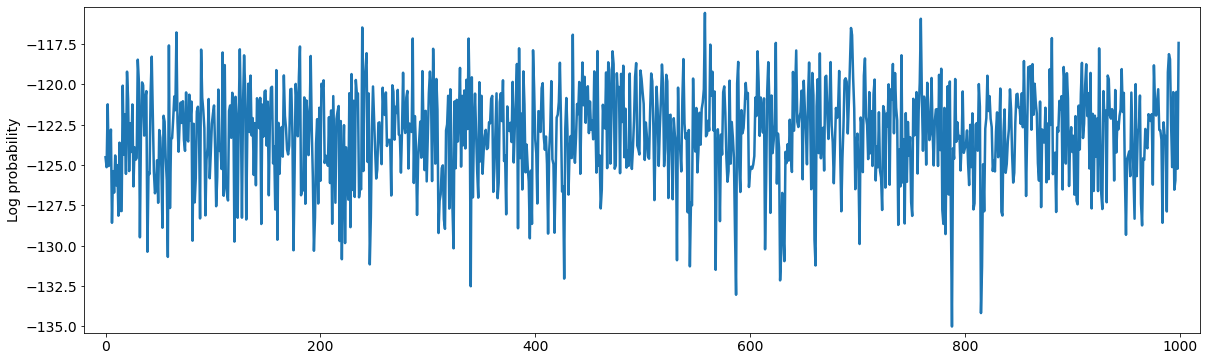

In [33]:
plot_log_prob(log_prob_test_results[:1000])

Let us also look at the diagnostics to ensure that the MCMC chains have converged to the posterior distribution. We note that [$\hat{R}$] (all are close to 1) and $n_{eff}$ (ESS) values look reasonable).

In [38]:
import arviz as az

with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # Arviz seems to throw a spurious Userwarning about num_chains > num_draws
    filtered_samples = {k: v for k, v in german_samples.items() if k in {model.beta(), model.lambda_()}}
    az_data = MonteCarloSamples(filtered_samples).to_inference_data()
az.summary(az_data, round_to=3)    

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta(SparseLogisticRegression with 25 covariates,)[0, 0]",-0.232,0.389,-1.143,0.208,0.010,0.007,1632.096,1838.653,1.000
"beta(SparseLogisticRegression with 25 covariates,)[1, 0]",-0.776,0.123,-0.999,-0.549,0.003,0.002,2149.637,1343.488,1.001
"beta(SparseLogisticRegression with 25 covariates,)[2, 0]",1.346,0.299,0.730,1.857,0.008,0.005,1500.186,1566.260,1.002
"beta(SparseLogisticRegression with 25 covariates,)[3, 0]",-0.482,0.204,-0.848,-0.070,0.006,0.004,1398.461,826.257,1.001
"beta(SparseLogisticRegression with 25 covariates,)[4, 0]",0.053,0.184,-0.335,0.416,0.004,0.003,2405.574,1606.407,1.002
"beta(SparseLogisticRegression with 25 covariates,)[5, 0]",-0.295,0.146,-0.532,0.007,0.004,0.003,1552.107,842.947,1.000
"beta(SparseLogisticRegression with 25 covariates,)[6, 0]",-0.340,0.184,-0.651,0.008,0.006,0.004,912.531,580.798,1.000
"beta(SparseLogisticRegression with 25 covariates,)[7, 0]",-0.138,0.160,-0.461,0.100,0.004,0.003,1509.006,1539.345,1.000
"beta(SparseLogisticRegression with 25 covariates,)[8, 0]",-0.015,0.087,-0.198,0.148,0.002,0.001,1738.155,1882.787,1.001
"beta(SparseLogisticRegression with 25 covariates,)[9, 0]",0.179,0.158,-0.045,0.491,0.004,0.003,1084.947,1468.868,1.000


To check for sparsity, let us plot the histogram of the marginals for a selection of coefficients ($\beta$) in the model. We note that many of the parameters have their posterior probability mass concentrated at 0, resulting in a sparse model, as we desired. 

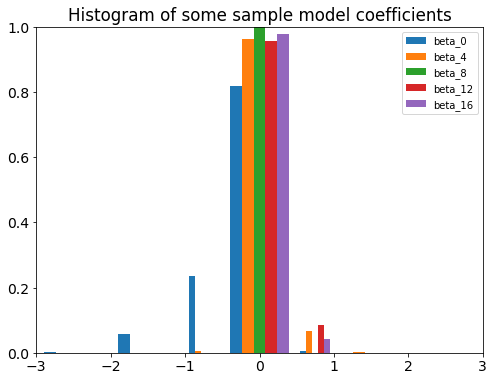

In [35]:
betas = german_samples[model.beta()].squeeze(-1).reshape(-1, 25)

idxs = [0, 4, 8, 12, 16]
bins = [-3, -2, -1, -0.5, 0.5, 1, 2, 3]
plt.hist(betas[:, idxs].numpy(), bins=bins, density=True, histtype='bar', label=[f'beta_{i}' for i in idxs])
plt.legend(prop={'size': 10})
plt.title('Histogram of some sample model coefficients')
plt.xlim(-3, 3);

Finally, let us evaluate the mean predictions from the model using the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (Receiver Operating Characteristic) plot. The area under the curve (AUC) is 0.83 which shows that the model is able to achieve a good classification accuracy. This is merely evaluating the mean forecast from the model, but as we saw earlier, we have a full distribution of the probability scores corresponding to each test data.

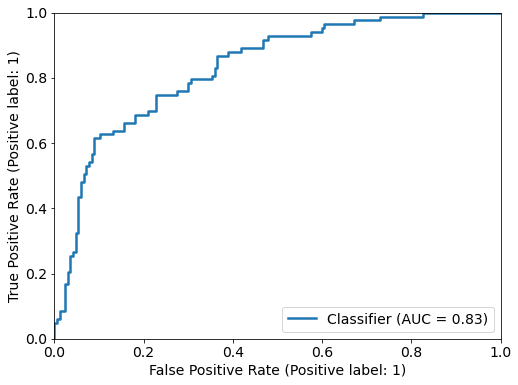

In [36]:
from sklearn.metrics import RocCurveDisplay

y_pred_mean = german_samples[model.y_probs()].squeeze(-1).mean([0, 1])
RocCurveDisplay.from_predictions(Y_test.squeeze(-1), y_pred_mean);